In [18]:
import torch
import torch.nn as nn

class ParticleTracker(nn.Module):
    def __init__(self, num_particles):
        super(ParticleTracker, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        
        # ConvLSTM
        self.convlstm = nn.LSTMCell(128*80*80, 128)  # Adjust based on encoder's output
        
        # Decoder
        self.decoder_x = nn.Linear(128, num_particles)
        self.decoder_y = nn.Linear(128, num_particles)
    
    def forward(self, x):
        batch_size, seq_length, channels, height, width = x.size()
        hidden, cell = None, None
        outputs_x, outputs_y = [], []

        for t in range(seq_length):
            # Encoder
            features = self.encoder(x[:, t])
            features = features.view(batch_size, -1)

            # ConvLSTM
            if hidden is None or cell is None:
                hidden, cell = self.convlstm(features)
            else:
                hidden, cell = self.convlstm(features, (hidden, cell))

            # Decoder
            out_x = self.decoder_x(hidden)
            out_y = self.decoder_y(hidden)
            outputs_x.append(out_x)
            outputs_y.append(out_y)

        outputs_x = torch.stack(outputs_x, dim=1)
        outputs_y = torch.stack(outputs_y, dim=1)

        return outputs_x, outputs_y




In [45]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

class ParticleDataset(Dataset):
    def __init__(self, image_paths, x_gt, y_gt, sequence_length=20):
        self.image_paths = image_paths
        self.x_gt = x_gt
        self.y_gt = y_gt
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.image_paths) - self.sequence_length + 1

    def __getitem__(self, idx):
        seq_images = []
        for i in range(self.sequence_length):
            img = cv2.imread(self.image_paths[idx + i])
            img = cv2.resize(img, (320, 320))
            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)/255
            seq_images.append(img)

        # Get the sequence of x and y coordinates for all particles
        #print (self.x_gt[0:10])
        #print (idx)
        x = self.x_gt[idx: idx + self.sequence_length]
        y = self.y_gt[idx: idx + self.sequence_length]

        return torch.stack(seq_images), x, y


# Example usage
top_dir='1000part_16xspeed_heterogeneous/'
train_image_paths = os.listdir(top_dir)
for i in range(len(train_image_paths)):
    train_image_paths[i] = os.path.join(top_dir,'Fig_'+str(i+1)+'.jpg')
train_image_paths=train_image_paths[0:20]
xc_data = pd.read_csv('xc_1000part_16xspeed.csv', header=None)
yc_data = pd.read_csv('yc_1000part_16xspeed.csv', header=None)
train_dataset = ParticleDataset(train_image_paths, np.array(xc_data)[:,0:800], np.array(yc_data)[:,0:800])
#train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
# def custom_collate_fn(batch):
#     images, x_gt, y_gt = zip(*batch)
    
#     # Ensure x_gt and y_gt are of consistent size
#     x_gt = [torch.tensor(x, dtype=torch.float32) if len(x) == 670 else torch.tensor(np.pad(x, (0, 670-len(x))), dtype=torch.float32) for x in x_gt]
#     y_gt = [torch.tensor(y, dtype=torch.float32) if len(y) == 670 else torch.tensor(np.pad(y, (0, 670-len(y))), dtype=torch.float32) for y in y_gt]
    
#     return torch.stack(images, 0), torch.stack(x_gt, 0), torch.stack(y_gt, 0)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False,  drop_last=False, num_workers=1)

In [46]:
#idx=0
#sequence_length=5
#yc_data.iloc[idx: idx + sequence_length]
#np.array(xc_data)[idx: idx + sequence_length]
#train_image_paths

In [47]:
# idx=0
# sequence_length=8
# x = np.array(xc_data.iloc[idx: idx + sequence_length])
# x[:,0]
xc_data.shape

(200, 1040)

In [48]:
np.any(np.isnan(xc_data.iloc[3]))

False

In [49]:
#train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
for batch in train_loader:
    images, x_gt, y_gt = batch
    print(x_gt.shape)  # should print torch.Size([12, 3, 224, 224])
    break

torch.Size([1, 20, 800])


In [33]:
for i in range(0):
    print( np.where(np.isnan(pd.DataFrame(x_gt[i]))))

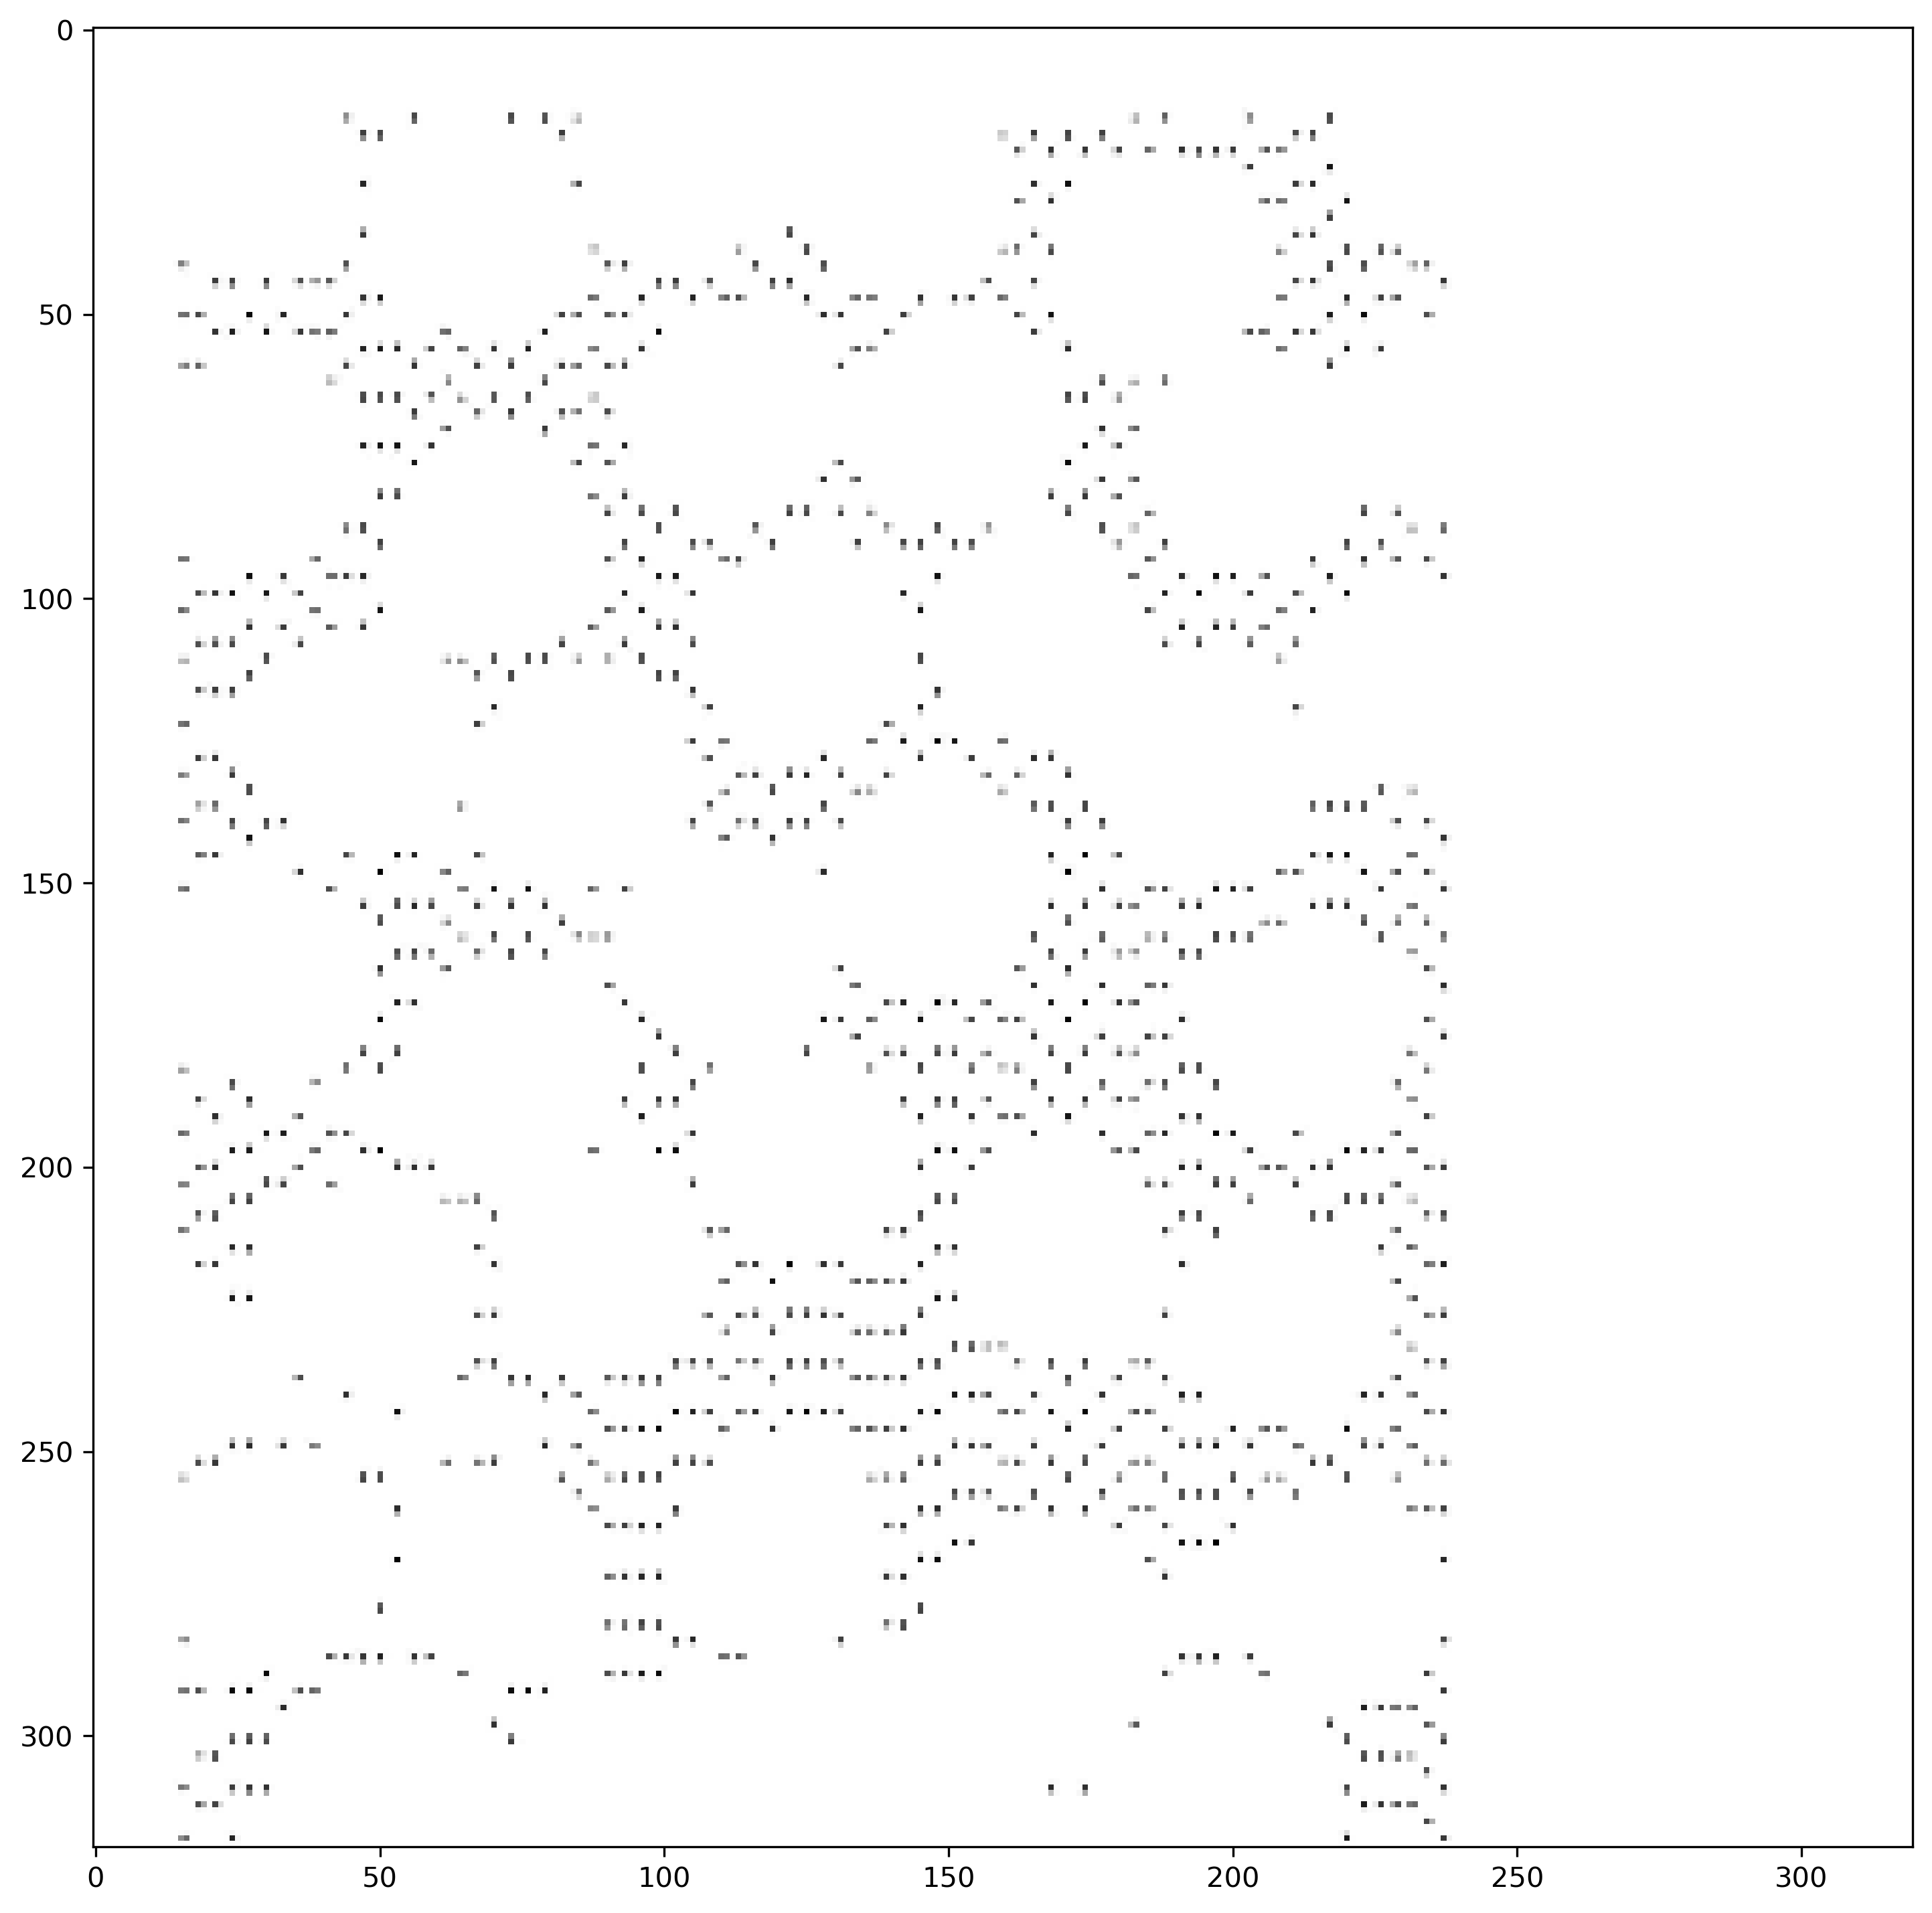

In [50]:
import matplotlib.pyplot as plt
#plt.plot(x_gt[0,:,:],y_gt[0,:,:])
plt.figure(figsize=(12, 12), dpi=300)
plt.imshow(images[0,0,0,:,:], cmap='gray')

In [9]:
images.shape

torch.Size([1, 20, 3, 320, 320])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ParticleTracker(num_particles=950).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10)
epochs=20000

for epoch in range(epochs):
    model.train()
    for images, x_gt, y_gt in train_loader:
        images = images.float().to(device)
        x_gt = x_gt.float().to(device)
        #x_gt[torch.isnan(x_gt)] = torch.mean(x_gt)
        y_gt = y_gt.float().to(device)
        #y_gt[torch.isnan(y_gt)] = torch.mean(y_gt)

        optimizer.zero_grad()
        
        x_pred, y_pred = model(images)
        loss = criterion(x_pred, x_gt) + criterion(y_pred, y_gt)
        scheduler.step(loss)
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        #print (loss)

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 228514.421875
Epoch 2, Loss: 15892.1259765625
Epoch 3, Loss: 15812.314453125
Epoch 4, Loss: 16516.7890625
Epoch 5, Loss: 16443.55078125
Epoch 6, Loss: 15687.037109375
Epoch 7, Loss: 14885.634765625
Epoch 8, Loss: 17749.2890625
Epoch 9, Loss: 16438.123046875
Epoch 10, Loss: 19403.0625
Epoch 11, Loss: 19403.0625
Epoch 12, Loss: 14725.6865234375
Epoch 13, Loss: 16438.123046875
Epoch 14, Loss: 14658.921875
Epoch 15, Loss: 17050.1875
Epoch 16, Loss: 18958.548828125
Epoch 17, Loss: 15297.6728515625
Epoch 18, Loss: 19403.0625
Epoch 19, Loss: 14885.6259765625
Epoch 20, Loss: 17388.80859375
Epoch 21, Loss: 15137.1904296875
Epoch 22, Loss: 14794.1494140625
Epoch 23, Loss: 14680.673828125
Epoch 24, Loss: 14794.1494140625
Epoch 25, Loss: 14885.6259765625
Epoch 26, Loss: 17749.2890625
Epoch 27, Loss: 17388.80859375
Epoch 28, Loss: 16733.208984375
Epoch 29, Loss: 14794.1494140625
Epoch 30, Loss: 18130.814453125
Epoch 31, Loss: 16164.984375
Epoch 32, Loss: 15137.1904296875
Epoch 33, Lo

KeyboardInterrupt: 

In [19]:
class TemporalTransformer(nn.Module):
    def __init__(self, num_particles, sequence_length, d_model=384, nhead=16, num_encoder_layers=12):
        super(TemporalTransformer, self).__init__()
        
        self.sequence_length = sequence_length
        
        # Initial convolution layer to extract features from the image
        self.conv = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        
        # Flatten and linear layer to match the transformer's input dimension
        self.fc = nn.Linear(256 * 80 * 80, d_model)  # Adjust based on conv output
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Decoders for x and y
        self.decoder_x = nn.Linear(d_model, num_particles)
        self.decoder_y = nn.Linear(d_model, num_particles)
    
    def forward(self, x):
        batch_size, seq_length, channels, height, width = x.size()
        assert seq_length == self.sequence_length, "Input sequence length doesn't match the defined sequence length"

        # Process each image in the sequence
        embeddings = []
        for t in range(seq_length):
            features = self.conv(x[:, t])
            embeddings.append(self.fc(features.view(batch_size, -1)))
        
        # Shape for transformer: S x N x E (sequence length x batch size x embedding dim)
        embeddings = torch.stack(embeddings).permute(1, 0, 2)
        
        # Pass through the transformer encoder
        transformer_out = self.transformer_encoder(embeddings)
        
        # Decode the transformer outputs for all images in the sequence
        out_x = self.decoder_x(transformer_out)
        out_y = self.decoder_y(transformer_out)
        
        return out_x, out_y

# Example usage

In [35]:
PATH_m='model/run1'
PATH_w='weights/run1'
model = torch.load(PATH_m).eval()
model.load_state_dict(torch.load(PATH_w),strict=False)

<All keys matched successfully>

In [51]:
x,y = model(images.to('cuda'))

AssertionError: Input sequence length doesn't match the defined sequence length

In [39]:
print (x[0,:,30])
print (x_gt[0,:,30])

tensor([143.0255, 143.0255, 143.0255, 143.0255, 143.0255, 143.0255, 143.0255,
        143.0255, 143.0255, 143.0255, 143.0255, 143.0255, 143.0255, 143.0255,
        143.0255, 143.0255, 143.0255, 143.0255, 143.0255, 143.0255, 143.0255,
        143.0255, 143.0255, 143.0255, 143.0255, 143.0255, 143.0255, 143.0255,
        143.0255, 143.0255], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([117.6481, 120.2037, 122.2929, 125.6039, 129.9123, 134.6232, 141.6045,
        150.4602, 161.6569, 176.8076, 195.2360, 221.4105, 256.6471, 303.6377,
        346.9615, 381.0006, 411.5712, 438.8294, 464.1088, 492.9041, 526.7396,
        562.9780,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan], dtype=torch.float64)


In [17]:
torch.mean(images[0])
torch.mean(images[1])


tensor(0.9969, device='cuda:0')

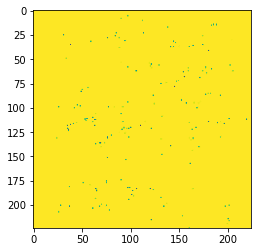

In [36]:
import matplotlib.pyplot as plt
plt.imshow(np.array(images[0][0].cpu()))

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#pip install deeptrack

     |██████████▍                     | 7.5 MB 127.6 MB/s eta 0:00:01

     |██████████████████              | 12.9 MB 127.6 MB/s eta 0:00:01

     |████████████████████████▉       | 17.8 MB 127.6 MB/s eta 0:00:01

     |████████████████████████████████| 22.9 MB 127.6 MB/s eta 0:00:01

     |████████████████████████████████| 22.9 MB 127.6 MB/s 
     |████████████████████████████████| 2.4 MB 150.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 120.1 MB/s eta 0:00:01
     |████████████████████████████████| 153 kB 112.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 127.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 198.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 182.6 MB/s eta 0:00:01
     |████████████████████████████████| 140 kB 100.3 MB/s eta 0:00:01
     |████████████████████████████████| 228 kB 184.2 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 9.4 MB/s s eta 0:00:01
  Created wheel for pint: filename=Pint-0.19.2-py3-none-any.whl size=230997 sha256=296ccdb448c23d0715497384e9bb5e59be6f6c082aacc01eb89135650fbe034b
  Stored in directory: /home/mbadhan/.cache/pip/wheels/4e/e3/93/6f6e5d37c9887117c3aede19f309becb52e0b461eddbb00270
  Created wheel for promise: filename=promise-2.

    Uninstalling protobuf-4.22.1:
      Successfully uninstalled protobuf-4.22.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
torchcam 0.3.2 requires torch<2.0.0,>=1.7.0, but you have torch 2.1.1 which is incompatible.


In [2]:
import deeptrack as dt
from deeptrack.models.gnns.generators import GraphGenerator

import tensorflow as tf

import pandas as pd
import numpy as np

from deeptrack.extras import datasets

import logging
logging.disable(logging.WARNING)

/home/mbadhan/anaconda3/envs/deeptrack/lib/python3.8/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/home/mbadhan/anaconda3/envs/deeptrack/lib/python3.8/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2023-12-10 03:12:43.741787: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 03:12:43.767153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild Tens

In [3]:
xc_data = pd.read_csv('xc_1000part_16xspeed.csv', header=None)
yc_data = pd.read_csv('yc_1000part_16xspeed.csv', header=None)

In [4]:
xc_data

,0,1,2,3,4,5,6,7,8,9,...,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039
0,99.639519,100.073342,100.238072,100.016433,99.738891,100.109834,100.170095,99.828468,99.926551,100.166968,...,1485.904273,1485.936030,1486.820386,1486.061056,1485.561924,1486.488906,1485.918701,1485.648019,1485.687871,1486.079147
1,104.105032,116.233261,107.640256,102.193077,104.136732,103.775111,102.290088,102.315419,102.167026,99.262228,...,1494.089195,1498.011122,1499.734787,1494.647196,1487.090757,1482.023060,1483.191619,1486.501299,1488.505462,1489.812748
2,109.065059,135.166732,117.046342,103.945471,109.231931,108.485236,104.714210,104.194805,104.122405,99.156254,...,1502.634123,1507.746720,1509.638034,1502.217346,1487.874145,1477.839586,1480.943414,1487.028044,1490.996923,1493.755629
3,113.693670,156.969043,126.338119,106.475461,113.723410,112.807552,106.832411,106.472211,106.687978,97.684472,...,1511.620851,1516.216961,1518.651604,1510.096051,1488.604123,1473.576509,1479.165582,1487.278572,1493.300747,1498.277024
4,119.104023,180.828458,136.741625,109.199788,119.617673,116.975336,109.051495,108.613240,108.562353,96.981164,...,1522.859748,1523.448902,1526.351650,1516.295501,1489.562657,1468.945901,1477.397026,1487.943906,1495.936763,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN,NaN,429.657591,NaN,NaN,323.027179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,NaN,NaN,NaN,NaN,NaN,NaN,430.135485,NaN,NaN,323.280793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,431.267662,NaN,NaN,324.038595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN,NaN,431.438673,NaN,NaN,324.317005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
import pandas as pd


def convert_trajectories_to_dataframe(x_file_path, y_file_path):
    """
    Convert the trajectory data into the required format.
    Args:
    - x_file_path (str): Path to the file containing x-coordinates.
    - y_file_path (str): Path to the file containing y-coordinates.

    Returns:
    - pd.DataFrame: DataFrame in the required format.
    """
    # Load the x and y data
    x_data = pd.read_csv(x_file_path, header=None)
    y_data = pd.read_csv(y_file_path, header=None)

    # Verify that x and y data have the same shape
    if x_data.shape != y_data.shape:
        raise ValueError("The x and y data must have the same dimensions.")

    # List to store each row before creating DataFrame
    rows = []

    # Iterate over each frame (row) and particle (column)
    for frame in range(x_data.shape[0]):
        for particle_id in range(x_data.shape[1]):
            row = {
                'label': particle_id,
                'centroid-0': x_data.iloc[frame, particle_id],
                'centroid-1': y_data.iloc[frame, particle_id],
                'frame': frame,
                'solution': 0.0,  # Assuming a default value for 'solution'
                'set': 0          # Assuming a default value for 'set'
            }
            rows.append(row)

    # Create DataFrame from the list of rows
    output_df = pd.DataFrame(rows)

    return output_df

# Example usage (paths to the x and y files need to be provided)
# df = convert_trajectories_to_dataframe("path_to_x_file.csv", "path_to_y_file.csv")
# print(df)


# Example usage (paths to the x and y files need to be provided)
df = convert_trajectories_to_dataframe("xc_1000part_16xspeed.csv", "yc_1000part_16xspeed.csv")
print(df)


        label  centroid-0  centroid-1  frame  solution  set
0           0   99.639519  261.655982      0       0.0    0
1           1  100.073342  315.596871      0       0.0    0
2           2  100.238072  369.962708      0       0.0    0
3           3  100.016433  585.567415      0       0.0    0
4           4   99.738891  640.011371      0       0.0    0
...       ...         ...         ...    ...       ...  ...
207995   1035         NaN         NaN    199       0.0    0
207996   1036         NaN         NaN    199       0.0    0
207997   1037         NaN         NaN    199       0.0    0
207998   1038         NaN         NaN    199       0.0    0
207999   1039         NaN         NaN    199       0.0    0

[208000 rows x 6 columns]


In [6]:
_OUTPUT_TYPE = "edges"

In [8]:
df['centroid-0'] = df['centroid-0']/np.max(df['centroid-0']) 
df['centroid-1'] = df['centroid-1']/np.max(df['centroid-1']) 

radius = 0.2

variables = dt.DummyFeature(
    radius=radius,
    output_type=_OUTPUT_TYPE,
    nofframes=3, # time window to associate nodes (in frames) 
)

model = dt.models.gnns.MAGIK(
    dense_layer_dimensions=(64, 120),      # number of features in each dense encoder layer
    base_layer_dimensions=(120, 120, 120),    # Latent dimension throughout the message passing layers
    number_of_node_features=2,             # Number of node features in the graphs
    number_of_edge_features=1,             # Number of edge features in the graphs
    number_of_edge_outputs=1,              # Number of predicted features
    edge_output_activation="sigmoid",      # Activation function for the output layer
    output_type=_OUTPUT_TYPE,              # Output type. Either "edges", "nodes", or "graph"
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, 2)]            0         []                            
                                                                                                  
 node_ide1 (Dense)           (None, None, 64)             192       ['input_5[0][0]']             
                                                                                                  
 lambda (Lambda)             multiple                     0         ['node_ide1[0][0]',           
                                                                     'edge_ide1[0][0]',           
                                                                     'node_ide2[0][0]',           
                                                                     'edge_ide2[0][0]',       

In [9]:

def generate_child_parent_dataframe(max_value):
    """
    Generate a DataFrame with child and parent values.
    
    Args:
    - max_value (int): The maximum value for the child column.

    Returns:
    - pd.DataFrame: DataFrame with columns 'child' and 'parent'.
    """
    # Lists to store child and parent values
    children = []
    parents = []

    # Generate child and parent values
    for i in range(max_value):
        children.append(i)
        parents.append(i)

    # Create DataFrame
    df = pd.DataFrame({'child': children, 'parent': parents})

    return df

# Generate DataFrame with child-parent pairs up to 1040
parenthood = generate_child_parent_dataframe(1040)
parenthood.head(10)  # Display first 10 rows for verification


,child,parent
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [10]:
_LOAD_MODEL = False

if _LOAD_MODEL:
    print("Loading model...")
    model.load_weights("datasets/BFC2DLMuSCTra/MAGIK.h5")
else:
    generator = GraphGenerator(
        nodesdf=df,
        properties=["centroid"],
        parenthood=parenthood,
        min_data_size=511,
        max_data_size=512,
        batch_size=32,
        **variables.properties()
    )
    
    with generator:
        model.fit(generator, epochs=10)

Creating graph edges...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [1:40:35<00:00, 6035.58s/it]


Generating 511 / 511 samples before starting training


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.